<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>Challenge Loan Approval Prediction in Pennsylvania</h1>
    <h3>Entrenamiento y evaluación de los modelos</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>

# Índice

1. [Importar librerias](#1.-Importar-librerias)
2. [Variables globales y funciones auxiliares](#2.-Variables-globales-y-funciones-auxiliares)
3. [Carga del dataframe](#3.-Carga-del-dataframe)
4. [Selección de las características](#4.-Seleccion-de-las-caracteristicas)
5. [Carga de los datos y división en entrenamiento y test](#5.-Carga-de-los-datos-y-division-en-entrenamiento-y-test)
6. [Modelos seleccionados](#6.-Modelos-seleccionados)
    * 6.1 [Introducción](#6.1-Introduccion)
    * 6.2 [Clasificador Random Forest](#6.2-Clasificador-Random-Forest)
    * 6.3 [Clasificador MLP](#6.3-Clasificador-MLP)
7. [Exportar CSV](#7.-Exportar-CSV)
    * 7.1 [Clasificador Random Forest](#7.1-Clasificador-Random-Forest)
    * 7.2 [Clasificador MLP](#7.2-Clasificador-MLP)

# 1. Importar librerias

In [1]:
# General import and load data
import pandas as pd
import numpy as np

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Splitting
from sklearn.model_selection import train_test_split

# Estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, roc_curve, roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Visualization
import matplotlib.pyplot as plt

# Time optimization
import time

print("Todas las librerias fueron correctamente importadas.")

Todas las librerias fueron correctamente importadas.


# 2. Variables globales y funciones auxiliares

Se fija un seed para todo el documento para fijar la aleatoriedad y así obtener resultados replicables.

In [2]:
seed = 42

Función utilizado para evaluar los distintos umbrales en la curva de ROC.

In [3]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

Función utilizada para estandarizar los datos en función del caso de preprocesado escogido.

In [4]:
def standard_data(case, X):
    
    if case in {1, 3, 5}:
        prep = StandardScaler().fit(X)
        X_scaled = prep.transform(X)
        
    elif case in {2, 4, 6}:
        prep = ColumnTransformer([
            ('numericas', StandardScaler(), numeric_vars)
        ], remainder='passthrough').fit(X) 
        X_scaled = prep.transform(X) 
        
    else:
        raise ValueError("El valor de 'case' no es válido. Debe estar entre 1 y 6.")
    
    return X_scaled, prep

Función utilizada para muestrear los datos en función del caso de preprocesado escogido.

In [5]:
def resample_data(case, X, y, strategy_under, strategy_over, neighbors=5):
    
    if case in {1, 2}:
        ovsamp = SMOTE(sampling_strategy=strategy_over, k_neighbors=neighbors, random_state=seed)
        X_resampled, y_resampled = ovsamp.fit_resample(X, y)
        
    elif case in {3, 4}:
        unsamp = RandomUnderSampler(sampling_strategy=strategy_under, random_state=seed)
        X_resampled, y_resampled = unsamp.fit_resample(X, y)
        
    elif case in {5, 6}:
        unsamp = RandomUnderSampler(sampling_strategy=strategy_under, random_state=seed)
        X_undersampled, y_undersampled = unsamp.fit_resample(X, y)
        ovsamp = SMOTE(sampling_strategy=strategy_over, k_neighbors=neighbors, random_state=seed)
        X_resampled, y_resampled = ovsamp.fit_resample(X_undersampled, y_undersampled)
        
    else:
        raise ValueError("El valor de 'case' no es válido. Debe estar entre 1 y 6.")
    
    return X_resampled, y_resampled

# 3. Carga del dataframe

Se cargan los datos de la ruta *formated/train_exportado.csv*, los cuales son los datos ya procesados por uno de nuestros compañeros.

In [6]:
url = "formated/train_exportado.csv"
df = pd.read_csv(url)

print("Datos cargados correctamente\n")

Datos cargados correctamente



También cargamos el test que debemos predecir para Kaggle de la ruta *formated/test_exportado.csv*.

In [7]:
url = "formated/test_exportado.csv"
df_test = pd.read_csv(url)

print("Test cargado correctamente\n")

Test cargado correctamente



# 4. Seleccion de las caracteristicas

Se seleccionan todas las características a excepción de las categoricas sin codificadar, al ya tener la misma információn codificada.

In [8]:
selected_features = [
    # Caracteristicas numericas
    'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross',

    # Caracteristicas categoricas binarias
    'NewExist_Binary', 'Franchise_Binary', 'UrbanRural_Binary',
    'RevLineCr_Binary', 'LowDoc_Binary', 'CreateJob_Binary',
    'RetainedJob_Binary',

    # Caracteristicas categoricas codificadas
    'Bank_Categorized_cod', 'BankState_Categorized_cod',
    'ApprovalFY_Grouped_cod', 'NoEmp_Grouped_cod', 
    'DisbursementGross_Grouped_cod',

     # Time-related features
    'ApprovalDate_quarter', 'DisbursementDate_quarter',

    # Caracteristicas relacionadas con BankState_Categorized tras un One Hot Encoding
    'BankState_DE', 'BankState_IL', 'BankState_OH', 
    'BankState_Otros', 'BankState_RI'
]

De las cuales, numéricas son las siguientes:

In [9]:
numeric_vars = ['ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross']

# 5. Carga de los datos y division en entrenamiento y test

Cargamos las caracteristicas seleccionadas en la variable X y el objetivo *Accept* en la variable y.

In [10]:
X = df[selected_features] 
y = df['Accept'].values

Se separa ya en entrenamiento y test para no falsear los datos del test al realizar el balanceo.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

A la hora de subir el modelo a Kaggle, ya se nos da dividido el entrenamiento y el test. Por ello, se utilizarán todos los datos tratados como entrenamiento (aunque también se le aplicará el mejor caso de preprocesado para cada modelo).

In [12]:
X_train_final = X
y_train_final = y

X_test_final = df_test[selected_features] 

# 6. Modelos seleccionados

## 6.1 Introduccion

En el anterior notebook se evaluaron 10 modelos tanto por F1 score como por ROC-AUC score. Los resultados de mayor a menor de los modelos respecto a la F1-Score fueron los siguientes:
* Random Forest: 0.867449
* MLP: 0.811513
* DecisionTree: 0.790538
* KNN: 0.767966
* LinearSVC: 0.664541
* LogReg: 0.663316
* SVC_sigmoid: 0.617281
* GaussianNB: 0.568654
* SVC_poly: 0.526099
* SVC_rbf: 0.411304

En cambio, los resultados de mayor a menor de los modelos respecto a la ROC-AUC Score fueron los siguientes:
* Random Forest: 0.934825
* MLP: 0.884770
* KNN: 0.874725
* DecisionTree: 0.795805
* LinearSVC: 0.715244
* LogReg: 0.715162
* GaussianNB: 0.705878
* SVC_rbf: 0.692410
* SVC_poly: 0.658396
* SVC_sigmoid: 0.556961

Se decidió entrenar y optimizar los hiperparámetros de cuatro modelos. Los modelos escogidos fueron Random Forest, MLP, KNN y LinearSVC, es decir, los cuatro primeros tanto por F1-score como por ROC-AUC score (se ha excluido Decision Tree por ya estar probando un clasificador basado en árbol de decisión, y en un principio mejor).

## 6.2 Clasificador KNN

### 6.2.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [13]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [14]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [15]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [16]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [17]:
pca = PCA()
X_pca_full = pca.fit_transform(X_resampled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_comp = np.argmax(cumulative_variance_ratio >= 0.95) + 1
X_pca = X_pca_full[:, :n_comp]

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

No es necesario realizar las tecnicas de muestreo ya que eso son técnicas para balancear nuestro conjunto de entrenamiento. Solamente es necesario realizar la misma estandarización de las características y aplicar la misma reducción de dimensionalidad.

In [18]:
X_test_scaled = prep.transform(X_test)
X_test_pca_full = pca.transform(X_test_scaled)
X_test_pca = X_test_pca_full[:, :n_comp]

### 6.2.2 Definicion

Definimos el modelo básico.

In [19]:
model_KNN = KNeighborsClassifier()

### 6.2.3 Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [20]:
model_KNN.fit(X_pca, y_resampled)

predicted_KNN = model_KNN.predict(X_test_pca)
expected_KNN = y_test

In [21]:
accuracy_score(expected_KNN, predicted_KNN)

0.6801771871539314

### 6.2.4 Null accuracy

Ahora se va a evaluar si  el modelo siempre predice la clase más frecuente.

In [22]:
s_y_test = pd.Series(y_test)
s_y_test.value_counts()

1    3765
0     750
Name: count, dtype: int64

In [23]:
y_test.mean()

0.8338870431893688

In [24]:
1 - y_test.mean() 

0.1661129568106312

In [25]:
max(y_test.mean(), 1 - y_test.mean())

0.8338870431893688

In [26]:
s_y_test.value_counts().head(1) / len(y_test)

1    0.833887
Name: count, dtype: float64

Nuestra exactitud es de 0.6801, la cual es peor que la *null accuracy*, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

### 6.2.5 Matriz de confusion y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [27]:
print(confusion_matrix(expected_KNN, predicted_KNN))

[[ 464  286]
 [1158 2607]]


In [28]:
print(classification_report(expected_KNN, predicted_KNN))

              precision    recall  f1-score   support

           0       0.29      0.62      0.39       750
           1       0.90      0.69      0.78      3765

    accuracy                           0.68      4515
   macro avg       0.59      0.66      0.59      4515
weighted avg       0.80      0.68      0.72      4515



Se observa lo que hemos estado comentando durante todo el documento, tenemos un f1-score del 0.78 para los 1s mientras que estamos obteniendo un 0.39 para los 0s

### 6.2.6 - ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

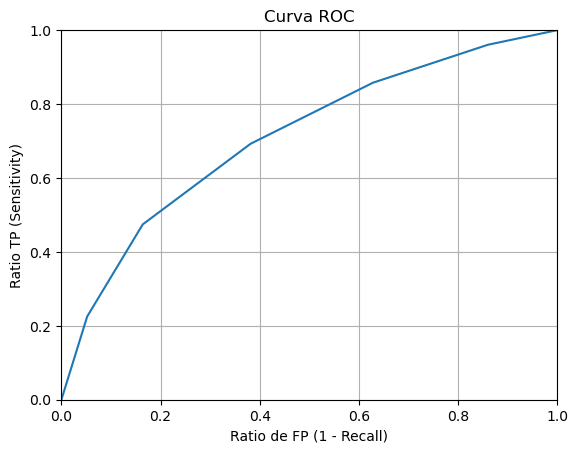

In [29]:
y_pred_prob_KNN = model_KNN.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_KNN)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [30]:
thresholds

array([inf, 1. , 0.8, 0.6, 0.4, 0.2, 0. ])

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

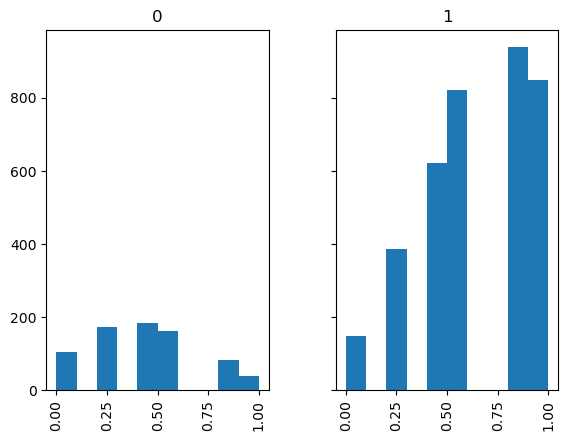

In [31]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_KNN, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra que los mejores resultados para ambas clases se obtiene con el *threshold* igual a 0.6.

In [ ]:
best_thres_KNN = 0.6

evaluate_threshold(best_thres_KNN)

Sensitivity: 0.6924302788844622
Recall: 0.6186666666666667


Con este valor se obtienen los siguientes resultados. Primero se recalculan las predicciones.

In [33]:
probs_KNN = model_KNN.predict_proba(X_test_pca)[:, 1]  
pred_thres_KNN = (probs_KNN >= best_thres_KNN).astype(int) 

Se evalua la matriz de confusión.

In [34]:
print(confusion_matrix(expected_KNN, pred_thres_KNN))

[[ 464  286]
 [1158 2607]]


Y también se analiza el informe de la clasificación.

In [35]:
print(classification_report(expected_KNN, pred_thres_KNN))

              precision    recall  f1-score   support

           0       0.29      0.62      0.39       750
           1       0.90      0.69      0.78      3765

    accuracy                           0.68      4515
   macro avg       0.59      0.66      0.59      4515
weighted avg       0.80      0.68      0.72      4515



Como se puede observar no hay cambios respecto a no utilizar threshold.

Finalmente se calcula el valor de AUC.

In [36]:
print(roc_auc_score(expected_KNN, predicted_KNN))

0.6555484727755645


Se ha obtenido un valor entre 0.6 y 0.7, es decir, el modelo se considerá como pobre o *D*.

### 6.2.7 - Optimizacion

Antes de nada, observamos cuales son los parámetros de nuestro modelo.

In [37]:
model_KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Ahora seleccionamos los parametros a evaluar mediante un GridSearchCV. Como se evalua mediante un *cross validation*, siempre escogeremos los casos 3 o 4 de preprocesado para falsear menos los datos.

Estos parametros son:
* n_neighbors:Representa el número de vecinos a considerar en el modelo KNN
* weights: Define cómo se ponderan los vecinos al calcular la predicción.
* algorithm: Define el algoritmo utilizado para encontrar los vecinos más cercanos

* p: Representa el parámetro de la distancia de Minkowski.

* leaf_size: Valores más bajos pueden hacer la búsqueda más precisa pero más lenta.
* metric: Define la métrica de distancia utilizada

### 6.2.8 Entramiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros (no se define con *grid_search.best_params_* para probar varias opciones de forma sencilla).

In [38]:
params_final_KNN = {
    "n_neighbors": 11, 
    "leaf_size": 30, 
    "metric": "minkowski", 
    "p": 1, 
    "weights": "uniform", 
    "algorithm": "auto"
}


Definimos el modelo desagregando el diccionario.

In [39]:
final_KNN = KNeighborsClassifier(**params_final_KNN)

#### - Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [40]:
final_KNN.fit(X_pca, y_resampled)

predicted_For_opt = final_KNN.predict(X_test_pca)
expected_For_opt = y_test

In [41]:
accuracy_score(expected_For_opt, predicted_For_opt)

0.697452934662237

#### - Matriz de confusion y F-score

La matriz de confusión y el informe de clasificación también es muy similar.

In [42]:
print(confusion_matrix(expected_For_opt, predicted_For_opt))

[[ 494  256]
 [1110 2655]]


In [43]:
print(classification_report(expected_For_opt, predicted_For_opt))

              precision    recall  f1-score   support

           0       0.31      0.66      0.42       750
           1       0.91      0.71      0.80      3765

    accuracy                           0.70      4515
   macro avg       0.61      0.68      0.61      4515
weighted avg       0.81      0.70      0.73      4515



#### - ROC y AUC

Cómo se ha visto antes el mejor threshold será 0.5, así que no se realiza este apartado.

### 6.2.9 Conclusiones

A continuación se muestra los resultados de los modelos optimizados y sin optimizar. Cabe recalcar que se probaron otros cuatro conjuntos de hiperparámetros para la mayoria de los casos de preprocesado, pero se acabó considerando absurdo porque mejoraba o empeoraba 0.01 en diversos valores.

Caso 1 : 

              precision    recall  f1-score   support

           0       0.27      0.64      0.38       750
           1       0.90      0.65      0.76      3765

    accuracy                           0.65      4515

Caso 2 : 

              precision    recall  f1-score   support

           0       0.27      0.59      0.37       750
           1       0.89      0.69      0.78      3765

    accuracy                           0.67      4515

Caso 3 : 

              precision    recall  f1-score   support

           0       0.30      0.66      0.41       750
           1       0.91      0.69      0.79      3765

    accuracy                           0.69      4515

Caso 4 : 

              precision    recall  f1-score   support

           0       0.31      0.66      0.42       750
           1       0.91      0.71      0.80      3765

    accuracy                           0.70      4515

Caso 5 : 

              precision    recall  f1-score   support

           0       0.31      0.47      0.38       750
           1       0.88      0.80      0.84      3765

    accuracy                           0.74      4515

Caso 6 : 

              precision    recall  f1-score   support

           0       0.33      0.45      0.38       750
           1       0.88      0.82      0.85      3765

    accuracy                           0.76      

En nuestro caso el mejor caso es el 6 o el 4 si nos fijamos en el f1 score de lso 0s.

# 7. Exportar CSV

## 7.1 Clasificador KNN

### 7.1.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [44]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [45]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.6
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [46]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [47]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [48]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [49]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.1.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades. En un principio, el valor del umbral era el de la variable *op_thres_Random*, pero se decidió finalmente que el valor del umbral fueran valores numéricos para que fuera más sencillo hacer diversas pruebas en Kaggle.

In [50]:
final_KNN.fit(X_pca_final, y_resampled_final)

probs_For_opt = final_KNN.predict_proba(X_test_pca_final)[:, 1]  
pred_thres_For_opt = (probs_For_opt >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [51]:
df_accept_KNN = pd.DataFrame(pred_thres_For_opt, columns=['Accept'])

In [52]:
df_id = df_test['id'].reset_index(drop=True)

In [53]:
df_final_KNN = pd.concat([df_id, df_accept_KNN], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [54]:
df_final_KNN['Accept'].value_counts()

Accept
1    2074
0    1210
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [55]:
df_final_KNN.to_csv('./knn.csv', index=False)